In [1]:
# pip install opencv-python

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Set dataset paths
dataset_path = "D:/Image Processing/Dataset/BSD500/images"
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "val")
test_path = os.path.join(dataset_path, "test")

# Load image file names
train_images = sorted(glob(os.path.join(train_path, "*.jpg")))
val_images = sorted(glob(os.path.join(val_path, "*.jpg")))
test_images = sorted(glob(os.path.join(test_path, "*.jpg")))

print(f"Train images: {len(train_images)}, Val images: {len(val_images)}, Test images: {len(test_images)}")

Train images: 200, Val images: 100, Test images: 200


# Visualize Some Sample Images

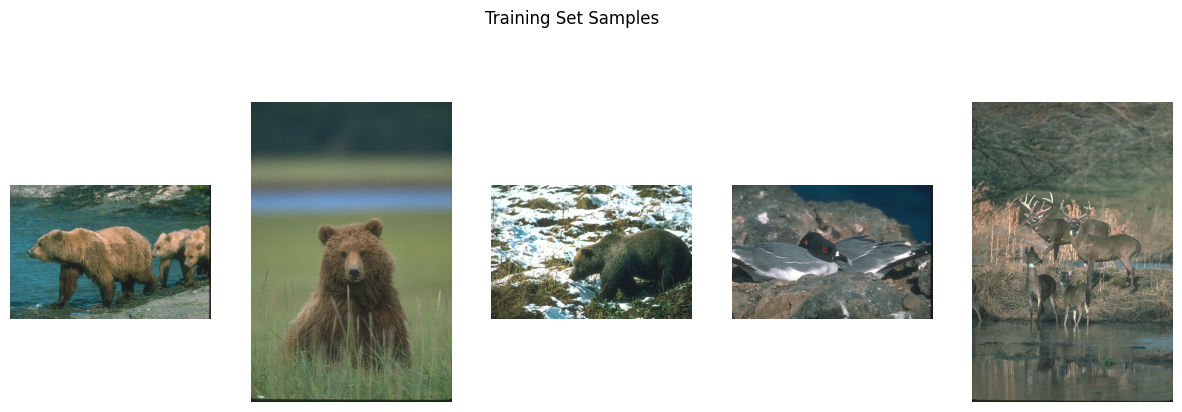

In [3]:
def show_images(image_list, title="Sample Images", num=5):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_list[:num]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
        plt.subplot(1, num, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Show training images
show_images(train_images, title="Training Set Samples")


# Add Synthetic Noise for Training

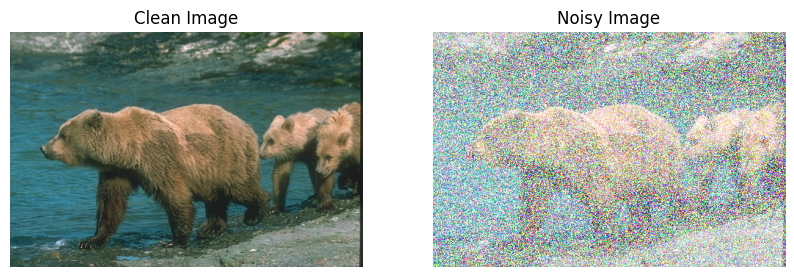

In [4]:
def add_gaussian_noise(image, mean=0, std=25):
    noise = np.random.normal(mean, std, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)  # Adds noise to the image
    return noisy_image

# Example: Show a clean vs noisy image
sample_img_path = train_images[0]
clean_img = cv2.imread(sample_img_path)
clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)  # Convert for display

noisy_img = add_gaussian_noise(clean_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(clean_img)
plt.title("Clean Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(noisy_img)
plt.title("Noisy Image")
plt.axis("off")

plt.show()

# Prepare Dataset for Training

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class DenoiseDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def add_gaussian_noise(self, image, mean=0, std=25):
        """Add Gaussian noise to the image"""
        noise = np.random.normal(mean, std, image.shape).astype(np.uint8)
        noisy_image = cv2.add(image, noise)
        return noisy_image

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Create noisy version
        noisy_image = self.add_gaussian_noise(image)

        # Convert to tensor
        if self.transform:
            image = self.transform(image)
            noisy_image = self.transform(noisy_image)

        return noisy_image, image  # (Noisy, Clean)

# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize((128, 128)),  # Resize images for training
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Create dataset
train_dataset = DenoiseDataset(train_images, transform=transform)
val_dataset = DenoiseDataset(val_images, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("Dataset Ready! 🚀")


Dataset Ready! 🚀


# Define the Denoising Model

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Initialize model
model = DenoisingCNN()  # Move to GPU if available
print(model)


DenoisingCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


# Define Loss and Optimizer

In [11]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train the Denoising Model

In [12]:
import time

# Set number of epochs
num_epochs = 10

# Loop over epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    start_time = time.time()
    
    for i, (noisy_images, clean_images) in enumerate(train_loader):
        # Move images to the device (CPU in this case)
        noisy_images = noisy_images.to(device)
        clean_images = clean_images.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(noisy_images)
        
        # Calculate loss (MSE)
        loss = criterion(outputs, clean_images)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        
        # Print every 100 mini-batches
        if i % 100 == 99:  # Print every 100 steps
            avg_loss = running_loss / 100
            print(f"Epoch {epoch+1}, Step {i+1}, Loss: {avg_loss:.4f}")
            running_loss = 0.0
    
    # Print epoch completion
    epoch_duration = time.time() - start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds. Loss: {running_loss/len(train_loader):.4f}")
    
    # Optionally, save the model after every epoch
    torch.save(model.state_dict(), f"denoising_model_epoch{epoch+1}.pth")

print("Training complete!")


D:\Anaconda\envs\pytorch_env\lib\site-packages\torch\autograd\graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 completed in 12.91 seconds. Loss: 0.1308
Epoch 2 completed in 10.09 seconds. Loss: 0.0370
Epoch 3 completed in 11.36 seconds. Loss: 0.0191
Epoch 4 completed in 10.04 seconds. Loss: 0.0157
Epoch 5 completed in 9.99 seconds. Loss: 0.0143
Epoch 6 completed in 10.02 seconds. Loss: 0.0133
Epoch 7 completed in 10.98 seconds. Loss: 0.0133
Epoch 8 completed in 10.25 seconds. Loss: 0.0132
Epoch 9 completed in 10.71 seconds. Loss: 0.0123
Epoch 10 completed in 10.27 seconds. Loss: 0.0120
Training complete!


# Validate the Model

In [13]:
# Validation loop
model.eval()  # Set the model to evaluation mode (disables dropout, batch norm)
validation_loss = 0.0

with torch.no_grad():  # No need to track gradients in validation
    for noisy_images, clean_images in val_loader:
        noisy_images = noisy_images.to(device)
        clean_images = clean_images.to(device)
        
        # Forward pass
        outputs = model(noisy_images)
        
        # Calculate loss
        loss = criterion(outputs, clean_images)
        
        # Accumulate loss
        validation_loss += loss.item()

avg_validation_loss = validation_loss / len(val_loader)
print(f"Validation Loss: {avg_validation_loss:.4f}")


Validation Loss: 0.0117


# Visualize Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6627451..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1209028..0.9944274].


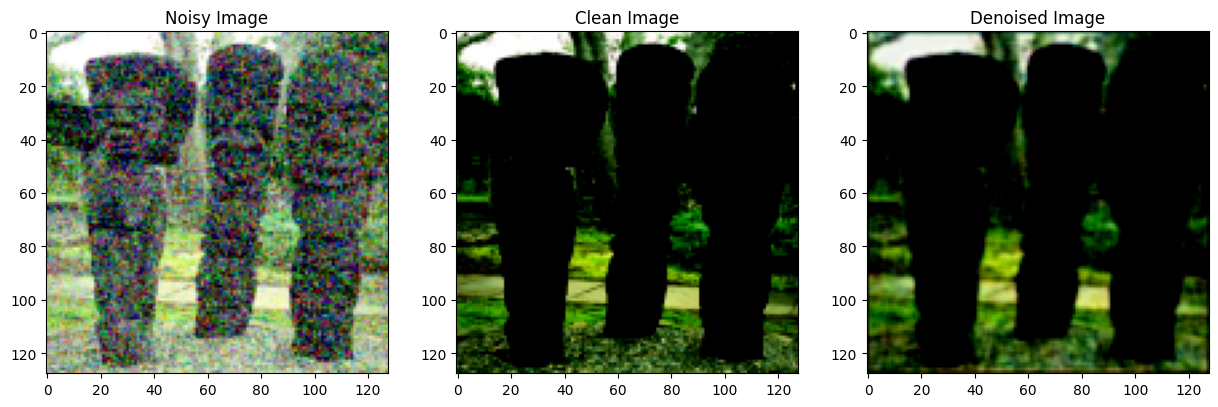

In [16]:
import matplotlib.pyplot as plt

# Visualize one example
model.eval()  # Set to evaluation mode
with torch.no_grad():
    noisy_image, clean_image = val_dataset[0]  # Grab one image
    noisy_image, clean_image = noisy_image.unsqueeze(0).to(device), clean_image.unsqueeze(0).to(device)

    # Forward pass (denoising)
    denoised_image = model(noisy_image)

    # Convert tensors back to numpy arrays for visualization
    noisy_image = noisy_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    clean_image = clean_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    denoised_image = denoised_image.squeeze().cpu().numpy().transpose(1, 2, 0)

    # Plot images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(noisy_image)
    axes[0].set_title("Noisy Image")
    axes[1].imshow(clean_image)
    axes[1].set_title("Clean Image")
    axes[2].imshow(denoised_image)
    axes[2].set_title("Denoised Image")
    plt.show()


In [19]:
# Saving the model for future use
torch.save(model.state_dict(), 'denoising_autoencoder.pth')
torch.save(model, 'denoising_autoencoder_full.pth')


In [18]:
####Loading the saved model
# # For state_dict loading:
# model = DenoisingAutoencoder()  # Make sure to initialize the model architecture first
# model.load_state_dict(torch.load('denoising_autoencoder.pth'))
# model.eval()  # Set the model to evaluation mode

# # For full model loading:
# model = torch.load('denoising_autoencoder_full.pth')
# model.eval()
